# Model finding

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Find or more suitable models
- Tune their parameters to improve their performances
- Evaluate their performance using different metrics

In [23]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

**Image retreiving was created due to memory problem, since it is solved by reducing csv shape it is not necessary anymore**

In [93]:
# Retreiving a significative amount of data
# from local_lib.dataset_images import retreiveDatasetFromImages

# dataset = retreiveDatasetFromImages(500)

In [4]:
dataset.iloc[0]["pixel_value"]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

**We use a custom flatten mask to make our data compatible with machine learning models**

In [24]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

In [13]:
import numpy as np
np.shape(X)

(5856, 35860)

In [14]:
np.unique(y)

array([0, 1, 2])

### First we restrict predicted data to 2 classes

In [15]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

array([0, 1])

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X, y_simpler, test_size=0.33, random_state=0)

# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = dummy_clf.score(X_test_simple, y_test_simple)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = round(dummy_clf.score(X_test_simple, y_test_simple) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_simple, y_train_simple)
ac = round(dummy_clf.score(X_test_simple, y_test_simple) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.6151060527677186% Accuracy
Using only most frequent number as answer we get 73.72% Accuracy
Using uniform distribution answer we get 52.56% Accuracy


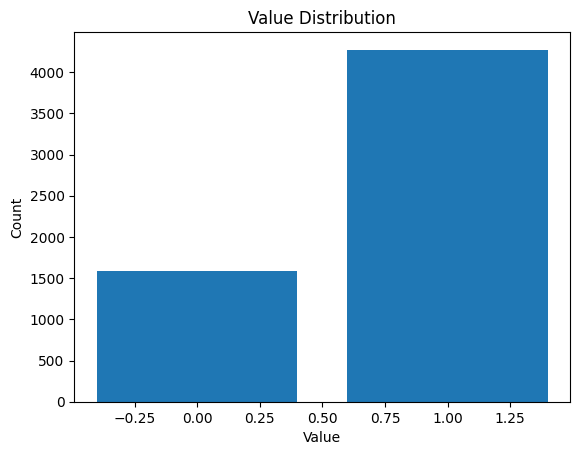

In [17]:
import matplotlib.pyplot as plt
unique_values, counts = np.unique(y_simpler, return_counts=True)

# Plot the bar chart
plt.bar(unique_values, counts)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Value Distribution')
plt.show()

**Uneven data distribution**

In [19]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Before applying SMOTE
print("Class distribution before SMOTE:")
print("Class 0:", sum(y_simpler == 0))
print("Class 1:", sum(y_simpler == 1))

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_simpler, y_resampled_simpler = smote.fit_resample(X, y_simpler)

# After applying SMOTE
print("\nClass distribution after SMOTE:")
print("Class 0:", sum(y_resampled_simpler == 0))
print("Class 1:", sum(y_resampled_simpler == 1))


Class distribution before SMOTE:
Class 0: 1583
Class 1: 4273

Class distribution after SMOTE:
Class 0: 4273
Class 1: 4273


In [20]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_resampled_simpler, y_resampled_simpler, test_size=0.33, random_state=0)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train_simple, y_train_simple)
accTrain = round(pipeline.score(X_train_simple, y_train_simple) * 100, 2)
accTest = round(pipeline.score(X_test_simple, y_test_simple) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 94.18% Accuracy - [TrainSet]
Combined mask accuracy is around 92.91% Accuracy - [TestSet]


Confusion matrix:
[[1407   22]
 [ 178 1214]]


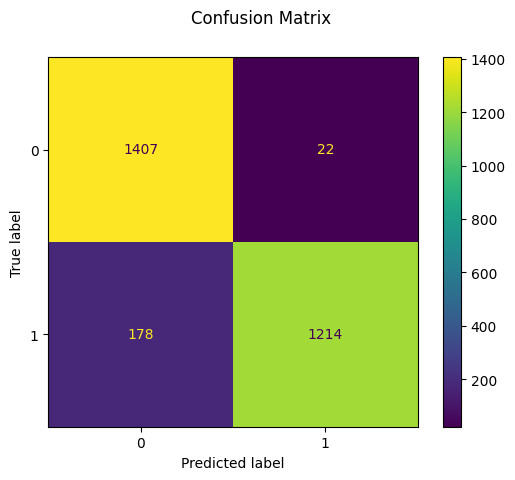

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_simpler = pipeline.predict(X_test_simple)
disp = ConfusionMatrixDisplay.from_predictions(y_test_simple, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### **Remarkable values without much confusion, quickly trying to optimize it**

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'image_mask__strategy': ["combined", "geometry", "baseline"],
              'knn__n_neighbors': range(4,15)
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=8,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled_simpler, y_resampled_simpler)


ac = round(random_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 94.08% Accuracy


{'knn__n_neighbors': 13, 'image_mask__strategy': 'combined'}

**n_neighbors: 13 and image_mask: combined seems to work well**

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', TesterTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {
              'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=4,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled_simpler, y_resampled_simpler)


ac = round(random_search.score(X_test_simple, y_test_simple) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 94.75% Accuracy


{'tester_tr__strategy': 'StandardScaler'}

**StandardScaler seems to improve performances a bit**

Displaying learning curve, recall and precision

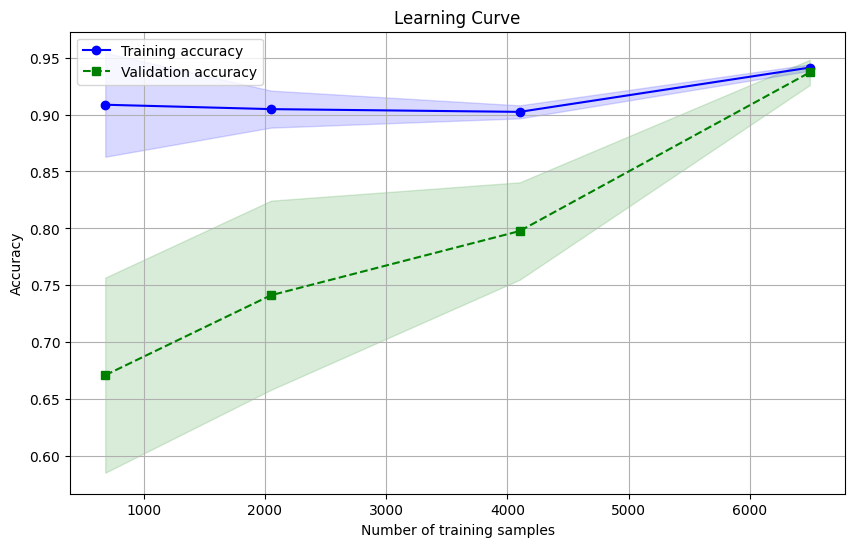

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_resampled_simpler,
    y=y_resampled_simpler,
    train_sizes=[0.1, 0.3, 0.6, 0.95],
    n_jobs=4,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score

# Make predictions on the test set
pipeline.fit(X_train_simple, y_train_simple)
y_pred = pipeline.predict(X_test_simple)

# Calculate precision and recall
precision = precision_score(y_test_simple, y_pred)
recall = recall_score(y_test_simple, y_pred)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.9644787644787645
Recall: 0.8972701149425287


### Recap:
 - 94.75% accuracy
 - 96.44 precision
 - 89.72 recall
 - homogeneous confusion matrix
 - coherent learning curve

### Now we try to extend to 3 classes

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [49]:
# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
ac = dummy_clf.score(X_test, y_test)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.3667873771339886% Accuracy
Using only most frequent number as answer we get 47.59% Accuracy
Using uniform distribution answer we get 32.9% Accuracy


### We can now get a first feed back from our differents data preprocessing strategies
To vizualize it we simply use a Knn models and scores it using our differents masks

**Baseline mask**

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 80.83% Accuracy - [TrainSet]
Combined mask accuracy is around 74.19% Accuracy - [TestSet]


**Geometry mask**

In [51]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 81.26% Accuracy - [TrainSet]
Combined mask accuracy is around 74.13% Accuracy - [TestSet]


**Combined mask**

In [52]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 80.47% Accuracy - [TrainSet]
Combined mask accuracy is around 73.46% Accuracy - [TestSet]


### From now on, combined mask seems to really overfit wich is an unexpected behavior since his main goal was to erase parasite datas
The best one so far is the **baseline strategy**

Trying to improve performance by adding different scalers

**StandardScaler**

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8050833333333334
Mean validation score: 0.7316666666666667


**MinMaxScaler**

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8087500000000001
Mean validation score: 0.7286666666666666


**Normalizer**

In [21]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8045833333333332
Mean validation score: 0.7230000000000001


### Now we look for the best n_neighbors params setup

In [26]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': range(1,20)}

model = GridSearchCV(
    pipeline,
    param_grid=param_grid
).fit(X, y)

ac = round(model.score(X_test, y_test) * 100, 2)
print("Scaled data upon knn accuracy is around " + str(ac) + "% Accuracy")
model.best_params_

Scaled data upon knn accuracy is around 75.15% Accuracy


{'knn__n_neighbors': 13}

**Value found produce a lower accuracy score but if we look bellow it stopped overfitting**

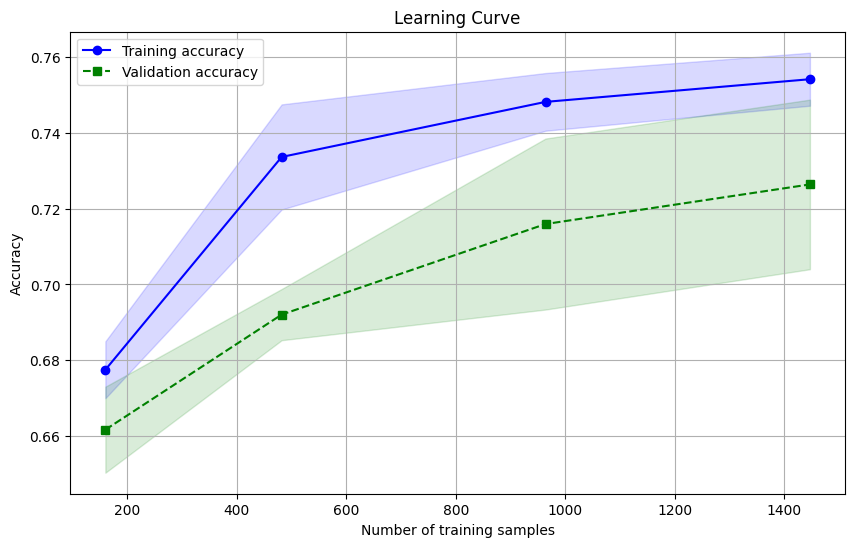

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.3, 0.5, 0.6, 0.9, 1, 2],
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### **Trying to confirm n_neighbors value**

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {'image_mask__strategy': ["combined", "geometry", "baseline"],
              'knn__n_neighbors': range(4,15)}

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=20,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X, y)


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 74.85% Accuracy


{'knn__n_neighbors': 12, 'image_mask__strategy': 'geometry'}

**Trying to combine differents transformer**

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('tester_tr', TesterTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {'image_mask__strategy': ["combined", "geometry", "baseline"],
              'knn__n_neighbors': range(4,15),
              'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=25,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X, y)


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 77.91% Accuracy


{'tester_tr__strategy': 'MinMaxScaler',
 'knn__n_neighbors': 13,
 'image_mask__strategy': 'geometry'}

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,
    train_sizes=[0.1, 0.3, 0.6, 0.9],
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
print(train_mean)
print(test_mean)

[0.71666667 0.76498221 0.76951324 0.7741637  0.77442467]
[0.68476813 0.72284912 0.72797163 0.73087426 0.7424871 ]


Confusion matrix:
[[413  45  64]
 [ 20 226 245]
 [ 12  88 820]]


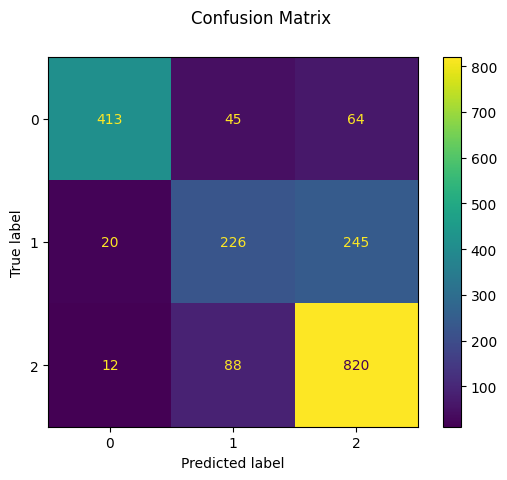

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


**Model is still confused on choosing wether or not it is bacteria or virus pneumonia**

### We reached a point of stagnation regarding all possibilities we listed
Now we are going to dig deeper into data repartation

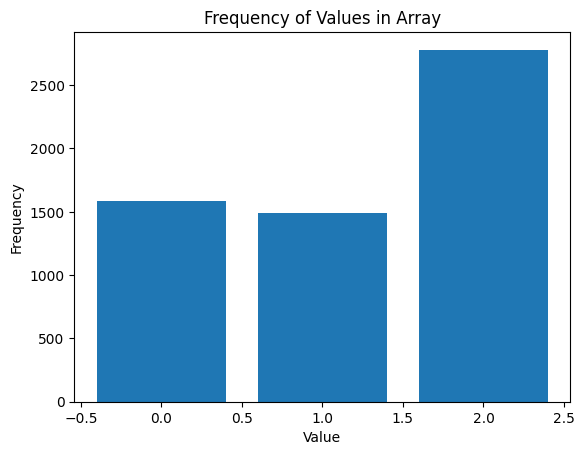

In [64]:
from collections import Counter


counter = Counter(y)

# Convert Counter to dictionary
grouped = dict(counter)

# Extract keys and values
keys = list(grouped.keys())
values = list(grouped.values())

# Plot the bar chart
plt.bar(keys, values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Array')
plt.show()


**Bacteria is almost twice as much represented in this dataset**<br>
It may leads to prediction issue with overweighted point of interest in images

We try to reequilibrate the dataset

In [25]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import numpy as np

# Before applying SMOTE
print("Class distribution before SMOTE:")
print("Class 0:", sum(y == 0))
print("Class 1:", sum(y == 1))
print("Class 2:", sum(y == 2))

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# After applying SMOTE
print("\nClass distribution after SMOTE:")
print("Class 0:", sum(y_resampled == 0))
print("Class 1:", sum(y_resampled == 1))
print("Class 2:", sum(y_resampled == 2))


Class distribution before SMOTE:
Class 0: 1583
Class 1: 1493
Class 2: 2780

Class distribution after SMOTE:
Class 0: 2780
Class 1: 2780
Class 2: 2780


In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

cv_results = cross_validate(pipeline, X_resampled, y_resampled, cv=3, return_train_score=True, n_jobs=4)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: nan
Mean validation score: 0.7344124700239808


Confusion matrix:
[[413  53  56]
 [ 19 236 236]
 [ 13 107 800]]


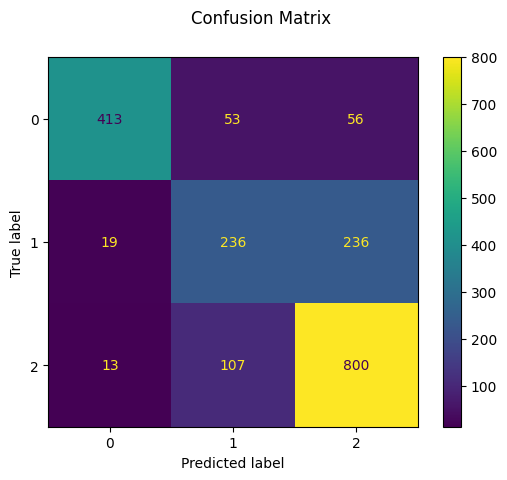

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


**No improvments at all**

## **Switching to linear SVC to see if any changes**

In [9]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', LinearSVC())
])

cv_results = cross_validate(pipeline, X, y, n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.9879607045761725
Mean validation score: 0.7178991439888314


**Testing poly svc version**

In [13]:
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', svm.SVC(kernel="poly", degree=4, C=1.5))
])

cv_results = cross_validate(pipeline, X[:1000], y[:1000], n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.9942500000000001
Mean validation score: 0.693


Way too much overfit

**RBF version**

In [49]:
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', MinMaxScaler()),
    ('svm', svm.SVC(kernel="rbf"))
])

cv_results = cross_validate(pipeline, X_resampled[:2500], y_resampled[:2500], n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8103
Mean validation score: 0.7732


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer
from sklearn import svm
import numpy as np

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', TesterTransformer()),
    ('svm', svm.SVC(kernel="rbf"))
])

param_grid = {
             'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=3,
                    cv=3,
                    n_jobs=8,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled[:1500], y_resampled[:1500])


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 79.93% Accuracy


{'tester_tr__strategy': 'StandardScaler'}

**StandardScaler again seems to work well**

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer
from sklearn import svm
import numpy as np

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', StandardScaler()),
    ('svm', svm.SVC(kernel="rbf"))
])

param_grid = {
              'svm__C': np.linspace(1, 3, num=8)
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=8,
                    cv=3,
                    n_jobs=8,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled[:1500], y_resampled[:1500])


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 81.89% Accuracy


{'svm__C': 1.8571428571428572}

**C: 1.8571428571428572**

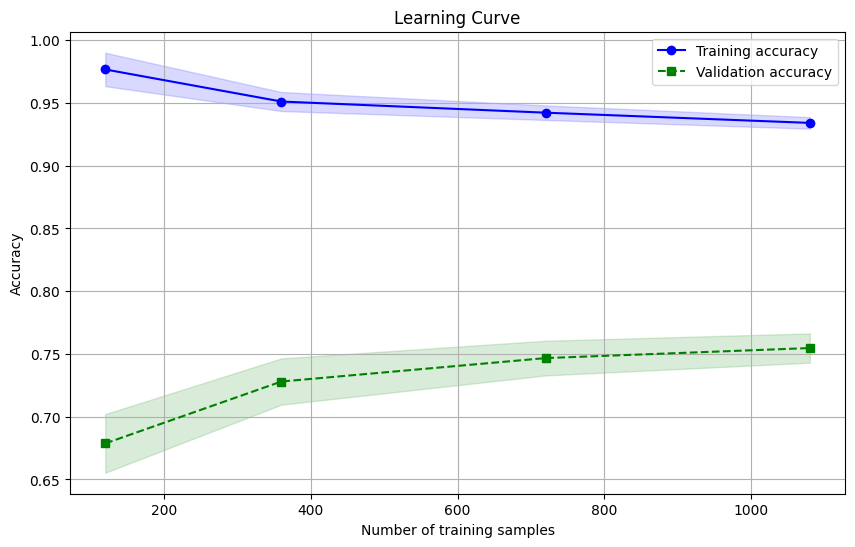

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', StandardScaler()),
    ('svm', svm.SVC(kernel="rbf", C=1.85))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_resampled[:1500],
    y=y_resampled[:1500],
    train_sizes=[0.1, 0.3, 0.6, 0.9],
    n_jobs=8,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### **Trying out model performances**

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', StandardScaler()),
    ('knn', svm.SVC(kernel="rbf", C=1.85))
])

cv_results = cross_validate(pipeline, X_resampled, y_resampled, cv=5, return_train_score=True, n_jobs=8)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 876, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 997, in partial_fit
    self.mean_, self.var_, self.n_samples_seen_ = _incremental_mean_and_var(
                                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py", line 1143, in _incremental_mean_and_var
    temp = X - T
           ~~^~~
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.78 GiB for an array with shape (6672, 35860) and data type float64

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chapu\Epitech\DEV810_Zoidberg\repo\IllnessRecognition\app\ml\local_lib\mask_transformer.py", line 29, in transform
    masked_image_array = np.where(mask == 1, reshaped_data, 0)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 280. KiB for an array with shape (163, 220) and data type int64


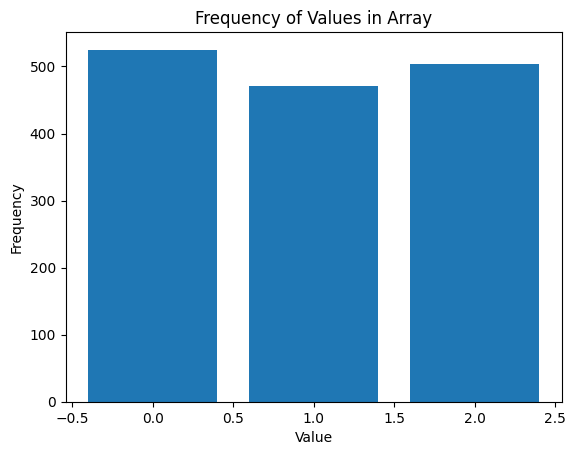

In [47]:
from collections import Counter
import matplotlib.pyplot as plt

random_indices = np.random.permutation(len(y_resampled))
X_randomized = X_resampled[random_indices]
y_randomized = y_resampled[random_indices]

counter = Counter(y_randomized[:1500])

# Convert Counter to dictionary
grouped = dict(counter)

# Extract keys and values
keys = list(grouped.keys())
values = list(grouped.values())

# Plot the bar chart
plt.bar(keys, values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Array')
plt.show()


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn import svm

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', StandardScaler()),
    ('knn', svm.SVC(kernel="rbf", C=1.85))
])

cv_results = cross_validate(pipeline, X_resampled[:1500], y_resampled[:1500], cv=5, return_train_score=True, n_jobs=8)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.9378333333333332
Mean validation score: 0.7833333333333334
